# GNATSS and Chadwell Fortran Benchmarking Demo

In this notebook, we will demonstrate the use of GNATSS to perform transponders positioning. We will then check the resulting values against the original Fortran code that GNATSS is based on. The Fortran program has been run ahead of time with its results found in the [`chadwell`](./chadwell/) directory. Here, we will run the same program using GNATSS and compare the results.

## Running the inversion

We will begin by running the inversion with the GNATSS software.
You can find the config file for this run at [`./gnatss/config.yaml`](./gnatss/config.yaml).
It has been set up that this run will use the same exact travel times (`./data/pxp_tt`) and sound speed (`./data/NDP1_Ch_Mi_2022_fit`) files as the original Chadwell inversion. 

It will also use the same deletions file (`./data/deletns.dat`) to remove the outlier data points to ensure that the results are comparable.

One difference is the input GNSS-A Level 2 Data. For this run, we are using a GNSS-A Level 2 Data from running the `posfilter` process in GNATSS `v0.2.0`, rather than the original Chadwell `POS_FREED_TRANS_TWTT`.

This input data has been checked and confirmed to similar to the original data, however we've found that there were bugs in the original processing that have been fixed in GNATSS `v0.2.0`, making the current input data to be more accurate. At the end of the notebook, we should see that the actual final values will be very close with a small rounding errors.

In [1]:
import gnatss
from gnatss.cli import run
from gnatss import constants

In [2]:
print(f"GNATSS Version: {gnatss.__version__}")

GNATSS Version: 0.2.0


The `run` function below in the `gnatss.cli` module is the entry point to running the software.
This is similar to directly running the `gnatss run` command from the command line. To start with, set the `remove_outliers` to `False` since this is the first time we are running the program. 

Additionally, by default, the run function will have `run_all` set to `True`, which means that the full end to end of `posfilter` and `solver` pipelines will be run. For the purpose of this benchmark, we will only run the solver, so we need to set `run_all` to `False`, and `solver` to `True`.

Starting GNATSS ...
Flag `from_cache` is set. Skipping data loading and processing for posfilter step.
Gathering travel_times at ./data/pxp_tt
Gathering sound_speed at ./data/NDP1_Ch_Mi_2022_fit
Gathering deletions at ./data/deletns.dat
Gathering gps_solution at ./data/gps_solution.csv
Loading travel_times from ./data/pxp_tt
Loading sound_speed from ./data/NDP1_Ch_Mi_2022_fit
Loading deletions from ./data/deletns.dat
Loading gps_solution from ./data/gps_solution.csv
Preprocessing Travel Times Data
Finished Preprocessing Travel Times Data
Computing harmonic mean...
lat=44.83268136 lon=-125.0997949 height=-1832.822 alt=-1832.822 internal_delay=0.2 sv_mean=1482.944 pxp_id='NDP1-1' azimuth=3.06 elevation=41.67
lat=44.81792965 lon=-125.12664945 height=-1829.645 alt=-1829.645 internal_delay=0.32 sv_mean=1482.944 pxp_id='NDP1-2' azimuth=-107.66 elevation=41.67
lat=44.8423252 lon=-125.13482028 height=-1830.76 alt=-1830.76 internal_delay=0.44 sv_mean=1482.944 pxp_id='NDP1-3' azimuth=134.54 elev

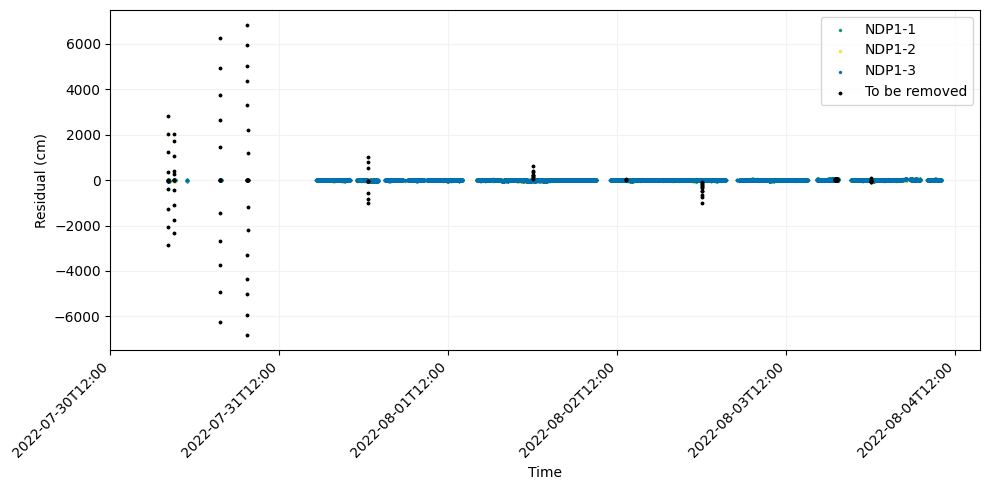

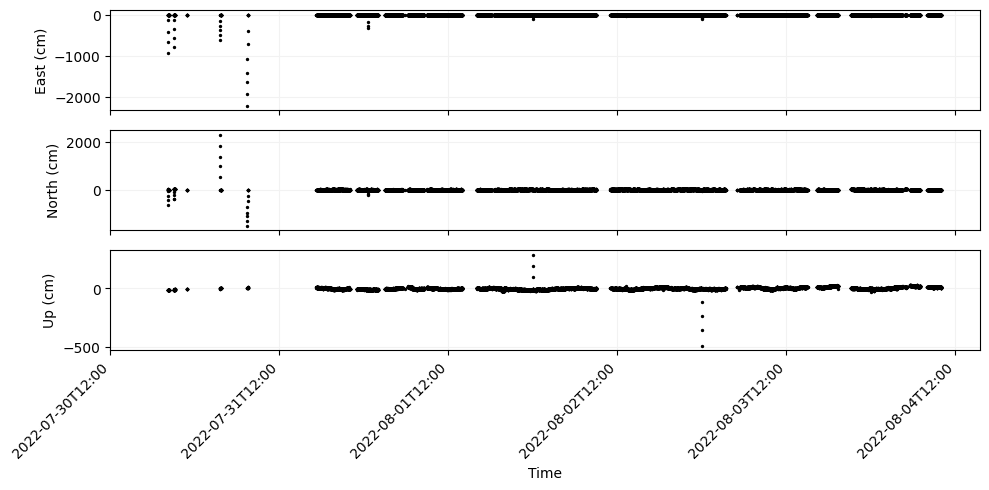

In [3]:
run(
    config_yaml="./config.yaml",
    extract_dist_center=True,
    extract_process_dataset=True,
    outlier_threshold=constants.DATA_OUTLIER_THRESHOLD,
    distance_limit=None,
    residual_limit=None,
    qc=True,
    remove_outliers=False, # Don't remove outliers to start with
    run_all=False,
    solver=True,
)

As you see on the residual plots above, there are some outliers still in the data that is waiting to be removed. These outliers are from a combination of the flagged points from the deletions file and residual limit configuration. To remove the outliers above we will run the function again below, but now `remove_outliers` is set to `True`.

Starting GNATSS ...
Flag `from_cache` is set. Skipping data loading and processing for posfilter step.
Gathering travel_times at ./data/pxp_tt
Gathering sound_speed at ./data/NDP1_Ch_Mi_2022_fit
Gathering deletions at ./data/deletns.dat
Gathering gps_solution at ./data/gps_solution.csv
Loading travel_times from ./data/pxp_tt
Loading sound_speed from ./data/NDP1_Ch_Mi_2022_fit
Loading deletions from ./data/deletns.dat
Found /Users/lsetiawan/Repos/SSEC/gnatss-fortran-benchmark/outputs/outliers.csv file. Including into cuts...
Loading gps_solution from ./data/gps_solution.csv
Preprocessing Travel Times Data
Finished Preprocessing Travel Times Data
Computing harmonic mean...
lat=44.83268136 lon=-125.0997949 height=-1832.822 alt=-1832.822 internal_delay=0.2 sv_mean=1482.944 pxp_id='NDP1-1' azimuth=3.06 elevation=41.67
lat=44.81792965 lon=-125.12664945 height=-1829.645 alt=-1829.645 internal_delay=0.32 sv_mean=1482.944 pxp_id='NDP1-2' azimuth=-107.66 elevation=41.67
lat=44.8423252 lon=-125.1

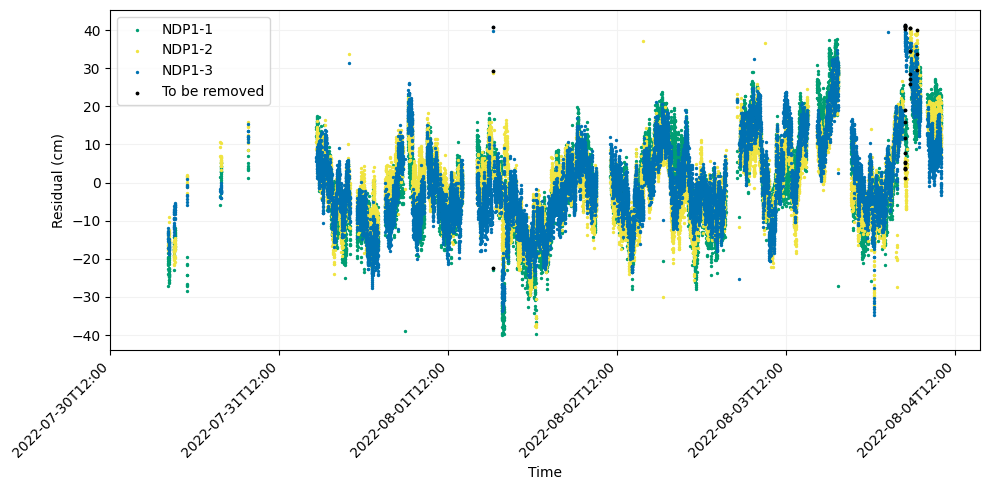

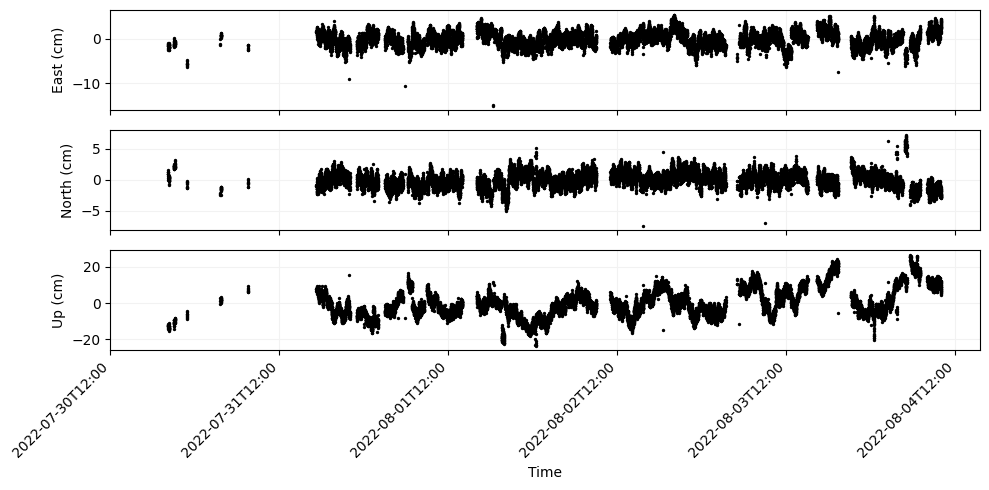

In [4]:
run(
    config_yaml="./config.yaml",
    extract_dist_center=True,
    extract_process_dataset=True,
    outlier_threshold=constants.DATA_OUTLIER_THRESHOLD,
    distance_limit=None,
    residual_limit=None,
    qc=True,
    remove_outliers=True,
    run_all=False,
    solver=True,
)

## Checking the results against the Fortran

Now that we have run the inversion with GNATSS, we can compare the results to the original Chadwell Fortran inversion.

In [5]:
from pathlib import Path
import yaml
import re
from functools import reduce
import pandas as pd
import numpy as np

### Get the GNATSS output

In [6]:
# Read the config file to see where the output path is
config_dict = yaml.safe_load(Path("./config.yaml").read_text())

In [7]:
# Get the output path from the configuration dictionary
output_dir = Path(config_dict["output"]["path"])

In [8]:
print("Output directory contains the following files:")
for i in output_dir.iterdir():
    print(i)

Output directory contains the following files:
outputs/outliers.csv
outputs/deletions.csv
outputs/residuals_enu_components.png
outputs/process_dataset.nc
outputs/residuals.png
outputs/residuals.csv
outputs/dist_center.csv


GNATSS output many result files, but the one we are interested in are the `residuals.csv` and `process_dataset.nc` files:
- The `residuals.csv` file contains the residuals for each time point in the inversion.
- The `process_dataset.nc` file contains the computed measurements during the run as well as the final results of the inversion.

In [9]:
# Load residuals csv into a dataframe and remove the iso_string column
gnatss_residuals = pd.read_csv(output_dir / "residuals.csv").drop("iso_string", axis="columns")

### Get the Chadwell Fortran outputs

In [10]:
chadwell_outputs = Path("./chadwell/")

In [11]:
print("Chadwell output contains the following files:")
for i in chadwell_outputs.iterdir():
    print(i)

Chadwell output contains the following files:
chadwell/res_09_NDP1_center_Ch_Mi_scale_xy_no_freed
chadwell/sol_out_NDP1_center_Ch_Mi_scale_xy_no_freed
chadwell/res_10_NDP1_center_Ch_Mi_scale_xy_no_freed
chadwell/README.md
chadwell/script.csh
chadwell/res_11_NDP1_center_Ch_Mi_scale_xy_no_freed


The Chadwell output directory also contains a lot of files, but the ones we are interested in are the `sol_out_*` and `res_*` files:
- The `sol_out_*` files contain the final result values and statistics of the inversion.
- The `res_*` files contain the residuals for each time point in the inversion.

In [12]:
# Read the solution output file
sol_out_file = chadwell_outputs / "sol_out_NDP1_center_Ch_Mi_scale_xy_no_freed"
sol_out_content = sol_out_file.read_text()

In [13]:
# Get the lines that contain the solution ONLY
final_text = '\n'.join(sol_out_content.splitlines()[78:97])

In [14]:
# Parse the solution values to data list of dictionaries
pattern = r'(?P<transponder>\d+) TRANSPONDER.*?x =\s+(?P<x>-?\d+\.\d+).*?del_e =\s+(?P<del_e>-?\d+\.\d+).*?y =\s+(?P<y>-?\d+\.\d+).*?del_n =\s+(?P<del_n>-?\d+\.\d+).*?z =\s+(?P<z>-?\d+\.\d+).*?del_v =\s+(?P<del_u>-?\d+\.\d+).*?Lat\. =\s+(?P<lat>\d+\.\d+).*?Long\. =\s+(?P<lon>-?\d+\.\d+).*?Hgt\.msl =\s+(?P<hgt>-?\d+\.\d+)'
matches = re.finditer(pattern, final_text, re.DOTALL)

data = []
for match in matches:
    data.append(match.groupdict())

In [15]:
# Read each transponder residual file into a list of dataframes
res_dfs = []
idx = 0
for i in sorted(chadwell_outputs.iterdir()):
    if "res_" in str(i):
        print(i)
        idx += 1
        resdf = pd.read_fwf(i, header=None)
        resdf.columns = ["time", f'{config_dict["site_id"]}-{idx}'] # use the site id from the GNATSS config file
        res_dfs.append(resdf)

chadwell/res_09_NDP1_center_Ch_Mi_scale_xy_no_freed
chadwell/res_10_NDP1_center_Ch_Mi_scale_xy_no_freed
chadwell/res_11_NDP1_center_Ch_Mi_scale_xy_no_freed


In [16]:
# Merge all the dataframes into one
chadwell_residuals = reduce(lambda x, y: pd.merge(x, y, on = 'time'), res_dfs).reset_index(drop=True)

## Compare the residuals

In [17]:
import matplotlib.pyplot as plt

In [18]:
# Same number of residuals
try:
    assert len(chadwell_residuals) == len(gnatss_residuals), f"The number of residuals in the GNATSS ({len(gnatss_residuals)}) and Chadwell ({len(chadwell_residuals)}) output files are not the same"
except AssertionError as e:
    print(e)

The number of residuals in the GNATSS (17732) and Chadwell (17759) output files are not the same


The number of residuals are not exactly the same since our input files differ slightly. This is okay and will not affect the end result below. We have successfully removed the same points that were flagged as outliers.

In [19]:
chadwell_residuals = chadwell_residuals.set_index("time")
gnatss_residuals = gnatss_residuals.set_index("time")

In [20]:
res_diff = chadwell_residuals.subtract(gnatss_residuals)

In [21]:
# Determine the number of subplots
num_plots = len(res_diff.columns)

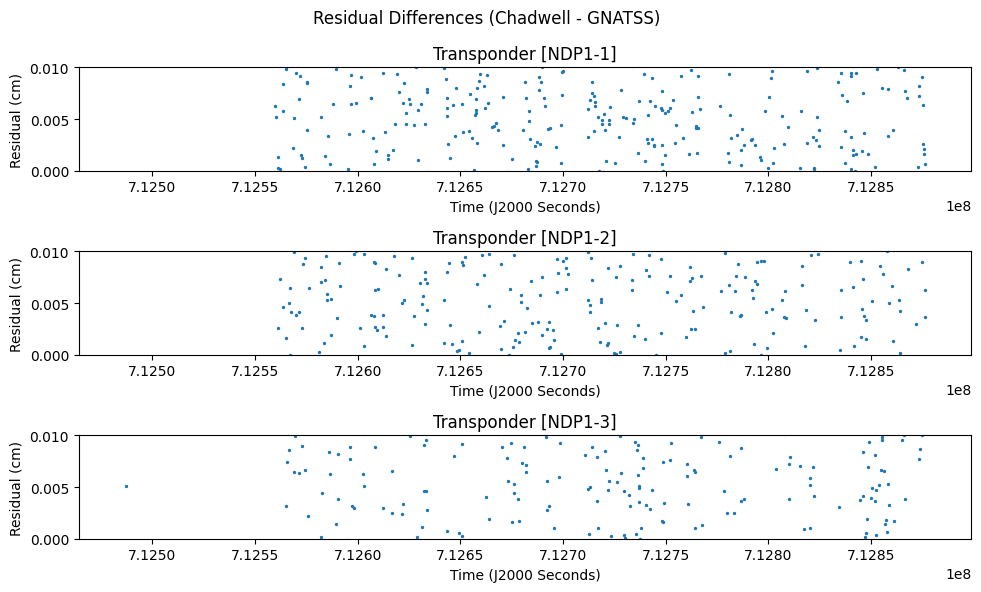

In [22]:
# Create figure with subplots
fig, axs = plt.subplots(num_plots, figsize=(10, num_plots*2))

for i,(k,v) in enumerate(res_diff.items()):
    v.to_frame().reset_index().plot(kind="scatter", x="time", y=k, s=2, ylim=(0,0.01), ax=axs[i])
    axs[i].set_ylabel("Residual (cm)")
    axs[i].set_xlabel("Time (J2000 Seconds)")
    axs[i].set_title(f"Transponder [{k}]")
    
fig.suptitle('Residual Differences (Chadwell - GNATSS)')

plt.tight_layout()
plt.show()

Due to the slight diffences in the way the two codes are written, the residuals are not exactly the same, but they are very close. The differences are less than 0.002 cm, which is very small compared to the values of the residuals themselves.

## Compare the solutions

The last check will be checking the actual solutions for the transponder positions. The GNATSS solution is in the `process_dataset.nc` file and the Chadwell Fortran solution is in the `sol_out_*` file that we have parsed above.

In [23]:
import xarray as xr

In [24]:
# Create transponder labels equivalency mapping
TP_LABELS = {
    "09": "NDP1-1",
    "10": "NDP1-2",
    "11": "NDP1-3",
}

In [25]:
# Read the process NetCDF file into an xarray dataset
gnatss_ds = xr.open_dataset(output_dir / "process_dataset.nc")

In [26]:
# Get the last iteration of run for comparison
last_ds = gnatss_ds.isel(iteration=-1)

In [27]:
# Go through each transponder and compare the values
for tres in data:
    tp = tres["transponder"]
    tp_label = TP_LABELS[tp]
    tp_ds = last_ds.sel(transponder=tp_label)
    
    # Get the Chadwell values
    chadwell_xyz = np.array([tres["x"], tres["y"], tres["z"]]).astype(float)
    chadwell_dels = np.array([tres["del_e"], tres["del_n"], tres["del_u"]]).astype(float)
    chadwell_latlonhgt = np.array([tres["lat"], tres["lon"], tres["hgt"]]).astype(float)

    # Print out the results
    print("-" * 30)
    print(f"=== Transponder {tres['transponder']} ===")
    print("GNATSS Label:", TP_LABELS[tres["transponder"]])
    print()
    print("- XYZ Inspection -")
    print("Chadwell XYZ:", chadwell_xyz)
    print("GNATSS XYZ:", tp_ds.transponders_xyz.data)
    print("XYZ Differences in meters:", np.abs(tp_ds.transponders_xyz.data - chadwell_xyz))
    print()
    print("- Delta ENU Inspection -")
    print("Chadwell Delta ENU:", chadwell_dels)
    print("GNATSS Delta ENU:", tp_ds.delta_enu.data)
    print("Delta ENU Differences:", np.abs(tp_ds.delta_enu.data - chadwell_dels))
    print()
    print("- Lat Lon Hgt Inspection -")
    print("Chadwell Lat Lon Hgt:", chadwell_latlonhgt)
    print("GNATSS Lat Lon Hgt:", tp_ds.transponders_lla.data)
    print("Lat Lon Hgt Differences:", np.abs(tp_ds.transponders_lla.data - chadwell_latlonhgt))
    print("-" * 30)

------------------------------
=== Transponder 09 ===
GNATSS Label: NDP1-1

- XYZ Inspection -
Chadwell XYZ: [-2604416.4042 -3705738.2206  4472870.9024]
GNATSS XYZ: [-2604416.40279812 -3705738.22110816  4472870.90345281]
XYZ Differences in meters: [0.00140188 0.00050816 0.00105281]

- Delta ENU Inspection -
Chadwell Delta ENU: [ 0.1806 -0.0268  0.2056]
GNATSS Delta ENU: [ 0.1820633  -0.0258209   0.20600009]
Delta ENU Differences: [0.0014633  0.0009791  0.00040009]

- Lat Lon Hgt Inspection -
Chadwell Lat Lon Hgt: [   44.83268112  -125.09979262 -1832.6164    ]
GNATSS Lat Lon Hgt: [   44.83268113  -125.0997926  -1832.61599991]
Lat Lon Hgt Differences: [9.58042534e-09 1.90543119e-08 4.00092874e-04]
------------------------------
------------------------------
=== Transponder 10 ===
GNATSS Label: NDP1-2

- XYZ Inspection -
Chadwell XYZ: [-2606819.0424 -3705463.8707  4471710.7685]
GNATSS XYZ: [-2606819.04090271 -3705463.8712343   4471710.76947981]
XYZ Differences in meters: [0.00149729 0.00

As you can see on the print out above that the differences in values for XYZ, Delta ENU, and Lat/Lon/Hgt are all less than 0.001. This is a very small difference and is likely due to the rounding off errors between the two programming languages: Python vs Fortran, and the input GNSS-A Level 2 Data file differences.